# **Parameter Optimisation for GITT** 

This notebook is created to provide an example for ```GITT``` optimisation problem. Diffisuion Coefficient is optimised in this notebook. 24 seperate discharge pulses are used in here.
 The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q # For Colab use
import pybamm
import pbparam
import pandas as pd
import os

folder_path = (os.path.join(pbparam.__path__[0], "input", "data/GITT"))

# Get a list of all files in the folder
all_files = os.listdir(folder_path)

# Filter the list to get only .csv files
csv_files = [file for file in all_files if file.endswith('.csv')]

In [2]:
# Extract pulse numbers from filenames and sort them
pulse_numbers = [int(file_name.split('_')[1].split('.csv')[0]) for file_name in csv_files]
sorted_files_by_pulse = [f"pulse_{num}.csv" for num in sorted(pulse_numbers)]

# Loop through each CSV file and read it into a DataFrame
dfs = {}  # Store each DataFrame in a dictionary with the filename as the key

for csv_file in sorted_files_by_pulse:
    file_path = os.path.join(folder_path, csv_file)
    dfs[csv_file] = pd.read_csv(file_path)

In [3]:
## OPTIONAL ##

# Calculation of Charge (Q)

def compute_cumulative_charge(currents, times, starting_charge):
    q_values = [starting_charge]
    for i in range (1, len(currents)):
        dt = times[i] - times[i-1]
        dq = 0.5 * (currents[i]+currents[i-1]) * dt
        q_values.append(q_values[-1] + dq)
    return q_values

In [4]:
# Charges are calculated and added as a new column to the dataframe.
starting_charge = 0
for name, df in dfs.items():
    currents = df["Current [A]"].tolist()
    times = df["Time [s]"].tolist()
    q_values = compute_cumulative_charge(currents, times, starting_charge)
    starting_charge = q_values[-1]
    dfs[name]['Charge (Q)'] = q_values

In [5]:
# Individual pulses can be printed as above.
dfs["pulse_1.csv"]

,Index,Time [s],Voltage [V],Current [A],Negative electrode potential [V],Positive electrode potential [V],Charge (Q)
0,227,12637.80,4.0310,5.002670,0.4051,4.5647,0.000000
1,228,12638.16,4.0194,4.999771,0.5024,4.5074,1.800439
2,229,12638.88,4.0099,5.000229,0.5123,4.5007,5.400439
3,230,12639.96,4.0040,4.999924,0.5148,4.4964,10.800522
4,231,12641.04,3.9992,4.999313,0.5164,4.4932,16.200110
...,...,...,...,...,...,...,...
269,496,16147.80,4.1089,0.000000,0.4448,4.5295,748.801044
270,497,16207.56,4.1086,0.000000,0.4455,4.5300,748.801044
271,498,16267.68,4.1089,0.000000,0.4456,4.5303,748.801044
272,499,16327.80,4.1086,0.000000,0.4455,4.5300,748.801044


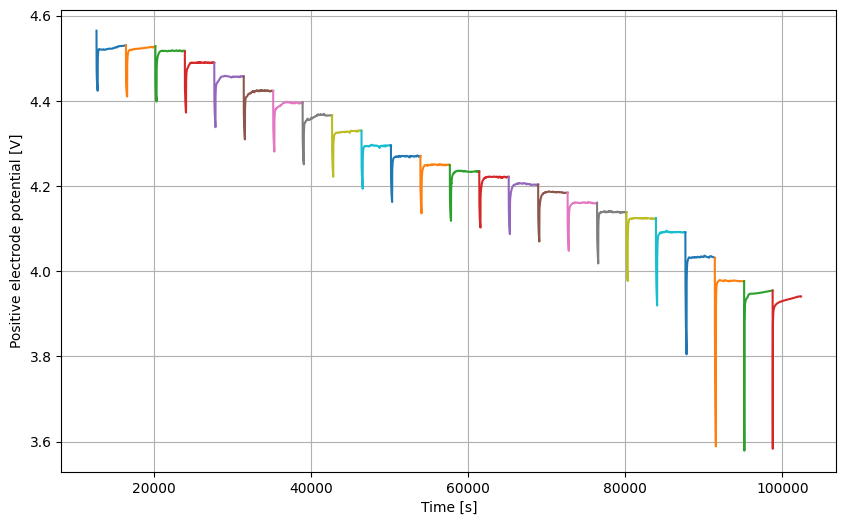

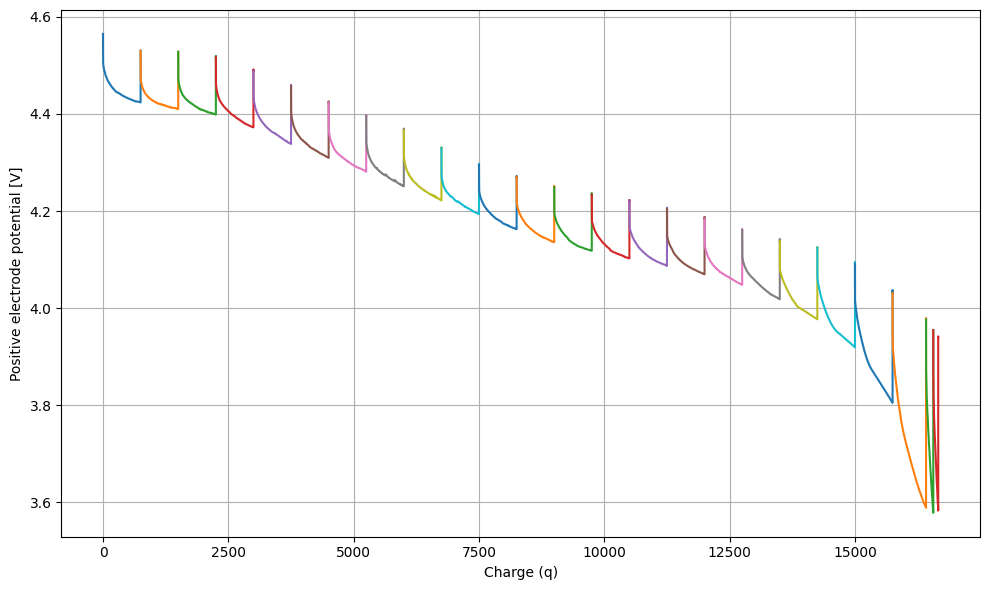

In [6]:
# Both of the Voltage vs Time and Charge can be plotted as below.

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
fig2, ax2 =plt.subplots(figsize=(10, 6))
for file_name, df in dfs.items():
    ax.plot(df['Time [s]'], df["Positive electrode potential [V]"])
    ax2.plot(df['Charge (Q)'], df["Positive electrode potential [V]"])
ax.set_xlabel('Time [s]')
ax2.set_xlabel('Charge (q)')
ax.set_ylabel('Positive electrode potential [V]')
ax2.set_ylabel('Positive electrode potential [V]')
ax.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()

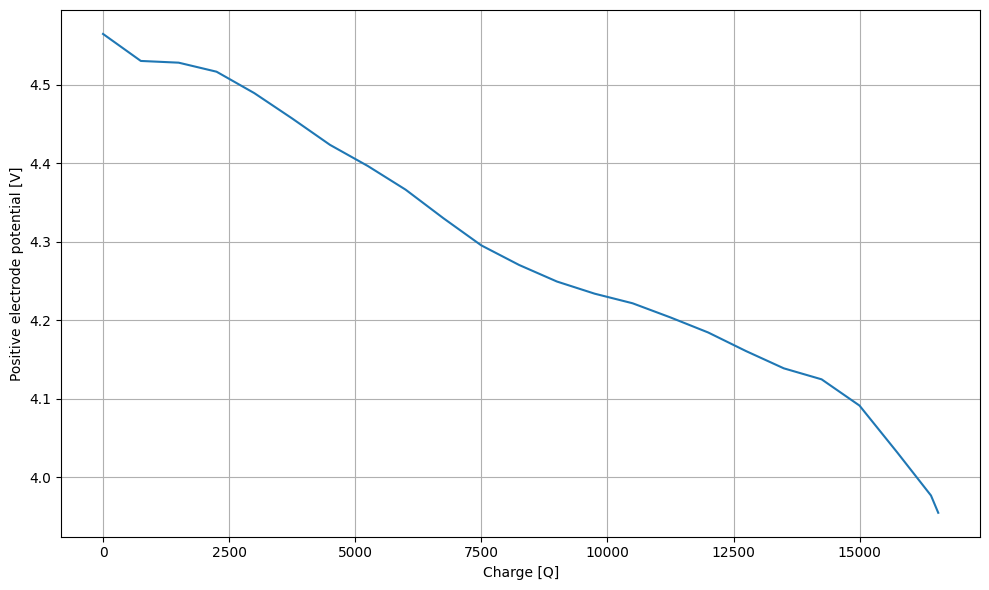

In [7]:
# Create a list to collect the first value from each DataFrame
first_values = [df['Positive electrode potential [V]'][0] for _, df in dfs.items()] # saving the first values of each pulse.
time_val = [df['Time [s]'][0] for _, df in dfs.items()]
charge_val = [df['Charge (Q)'][0] for _, df in dfs.items()]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(charge_val,first_values)
# ax.set_xlabel('Time [s]')
ax.set_xlabel('Charge [Q]')
ax.set_ylabel('Positive electrode potential [V]')
ax.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# For BasicGITT, we need derivatives of each pulse which can be calculated as:
import numpy as np
grad = np.gradient(first_values,time_val)

PbParam model to be used for GITT needs to be defined:

In [9]:
model = pbparam.BasicGITT()

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower value for most of the cases. 

In [10]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

Next, parameter dictionary needs to be defined with all of the required parameters:

In [11]:
param_dict=pybamm.ParameterValues({
        "Reference OCP [V]": first_values[0],
        "Derivative of the OCP wrt stoichiometry [V]": grad[0],
        "Current function [A]": 0.680616,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Electrode width [m]": 0.207,
        "Electrode height [m]": 0.137,
        "Positive electrode active material volume fraction": 0.5,
        "Positive particle radius [m]": 1e-05,
        "Positive electrode thickness [m]": 0.0001,
        "Positive electrode diffusivity [m2.s-1]": 5e-14,
        "Maximum concentration in positive electrode [mol.m-3]": 51217.9257309275,
        "Initial concentration in positive electrode [mol.m-3]": 1000,
        "Effective resistance [Ohm]": 0,
        'Negative electrode thickness [m]': 0.0001,
        'Separator thickness [m]': 0.0001,
        'Negative particle radius [m]': 1e-05,
    })

The Diffusuvity is optimised for every pulse in a loop as below:

In [12]:
i = 0
results = []
diffusions = []
for name, df in dfs.items():
    #Parameter dictionary updated for every pulse
    param_dict.update({
        "Reference OCP [V]": first_values[i],
        "Derivative of the OCP wrt stoichiometry [V]": grad[i],
    })
    # Time [s] should start from 0 for every pulse! (Otherwise it will NOT work!)
    df['Time [s]'] = df['Time [s]']-df['Time [s]'][0]

    # We are doing this for positive electrode potential 
    # but it needs to be converted to 'Voltage [V]'
    pulse_data = df.filter(items=['Time [s]', 'Positive electrode potential [V]'])
    pulse_data.rename(columns={'Positive electrode potential [V]': 'Voltage [V]'}, inplace=True)

    # Optimisation problem is defined here.
    opt = pbparam.GITT(param_dict=param_dict,gitt_model=model, data=pulse_data)

    #Optimisation is done in step and saved in result.
    result = optimiser.optimise(opt)

    # Diffisuion coefficient is the first one in the result.
    diffusions.append(result.x[0])

    # They can be plotted using:
    #result.plot()

    # All of the results are stored.
    results.append(result) 
    i +=1

In [13]:
diffusions

[3.023892640236145e-13,
 2.06e-12,
 2.06e-12,
 2.9347470517790345e-13,
 2.3592188194935207e-13,
 2.405938093410363e-13,
 2.94338297415171e-13,
 2.694523697915224e-13,
 2.339341326563588e-13,
 3.184593786558306e-13,
 3.0559132131725915e-13,
 3.0657504861940735e-13,
 3.4290668609850543e-13,
 3.456253999598726e-13,
 3.001523441375766e-13,
 3.102382762856472e-13,
 3.1601462592961013e-13,
 3.1946679921911487e-13,
 2.9055195867009175e-13,
 2.0753991576023668e-13,
 1.6986589437203287e-13,
 1.8897304831154233e-13,
 2.06e-12,
 2.06e-12]